In [10]:
import cudf as cf

eurgbp = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurgbp-m1-bid-2015-01-01-2025-01-30T14:40.csv', index_col=0)
eurgbp_after23 = eurgbp[eurgbp.index > '2023-01-01']

### Huge classic: the Hurst Exponent

In [ ]:
import cudf
import cupy as cp


# Calculate the Hurst exponent using cupy
def compute_Hc_cupy(data, kind='price'):
    N = len(data)
    T = cp.arange(1, N + 1)
    Y = cp.cumsum(data - cp.mean(data))
    R = cp.max(Y) - cp.min(Y)
    S = cp.std(data)
    H = cp.log(R / S) / cp.log(T[-1])
    return H.get()

H_cupy = compute_Hc_cupy(cp.array(eurgbp_after23['close']))
print(f"Hurst exponent (cupy): {H_cupy}")

# Alternative methods

Below is more information and examples for the two methods:

### Range-Based Volatility  
Range-based measures use the high and low prices to estimate volatility. They tend to be more efficient because they use more information than just closing prices. Two common estimators are:

- **Parkinson Estimator:**  
  Uses the high and low prices. Its formula is:  
  σ² = (1 / (4 ln(2) T)) * Σ[ln(High/Low)]²  
  It assumes zero drift and no opening/closing jumps.

- **Rogers-Satchell Estimator:**  
  Incorporates opening and closing prices along with the high and low. It can better handle assets with drift. Its formula is:  
  σ² = ln(High/Close) * ln(High/Open) + ln(Low/Close) * ln(Low/Open)

Example for Parkinson estimator:



In [12]:
import numpy as np
import pandas as pd

def parkinson_volatility(high: pd.Series, low: pd.Series) -> float:
    log_range = np.log(high / low)
    squared_log_range = log_range ** 2
    # 4 * ln(2) factor from the estimator
    volatility_squared = squared_log_range.mean() / (4 * np.log(2))
    return np.sqrt(volatility_squared)

# Example usage:
# data = pd.read_csv('eur_gbp_prices.csv', parse_dates=['Date'], index_col='Date')
# volatility = parkinson_volatility(data['High'], data['Low'])
# print("Parkinson Volatility:", volatility)



### Realized Volatility  
Realized volatility uses high-frequency intraday data. By summing the squared returns within a day, you get a measure that reflects the day’s true volatility more directly. The formula is usually:  

RV = sqrt(Σ r_t²)  

where r_t represents high-frequency returns (e.g., 5-minute log returns).

Example for calculating daily realized volatility from intraday data:



In [13]:
import numpy as np
import pandas as pd

def realized_volatility(returns: pd.Series) -> float:
    # Sum of squared returns in a day
    rv = np.sqrt((returns ** 2).sum())
    return rv

# Example usage:
# data = pd.read_csv('intraday_returns.csv', parse_dates=['Timestamp'], index_col='Timestamp')
# # Group data by day and compute volatility for each day:
# daily_vol = data.groupby(data.index.date)['Return'].apply(realized_volatility)
# print(daily_vol)



Each method has its assumptions and data needs. The range-based estimators are good with daily high/low (and possibly open/close) data, while realized volatility requires high-frequency data but can capture intraday fluctuations more accurately.

## Basic realized volatility

In [32]:
import cudf as cf

eurgbp = cf.read_parquet('/home/edoardocame/Desktop/python_dir/data/eurgbp_merged.parquet')
returns = eurgbp['close'].pct_change().abs() * 100 #questi sono i ritorni su dati da un minuto;
returns = returns.resample('1D').sum()
returns.dropna(inplace=True)
sma_14 = returns.rolling(14).mean()
sma_14.dropna(inplace=True)

In [ ]:
line1 = returns.to_pandas()
line2 = sma_14.to_pandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(line1, label='Returns')
plt.plot(line2, label='SMA 14')
plt.legend()
plt.show()

## An Absolute Momentum indicator

<Axes: xlabel='date'>

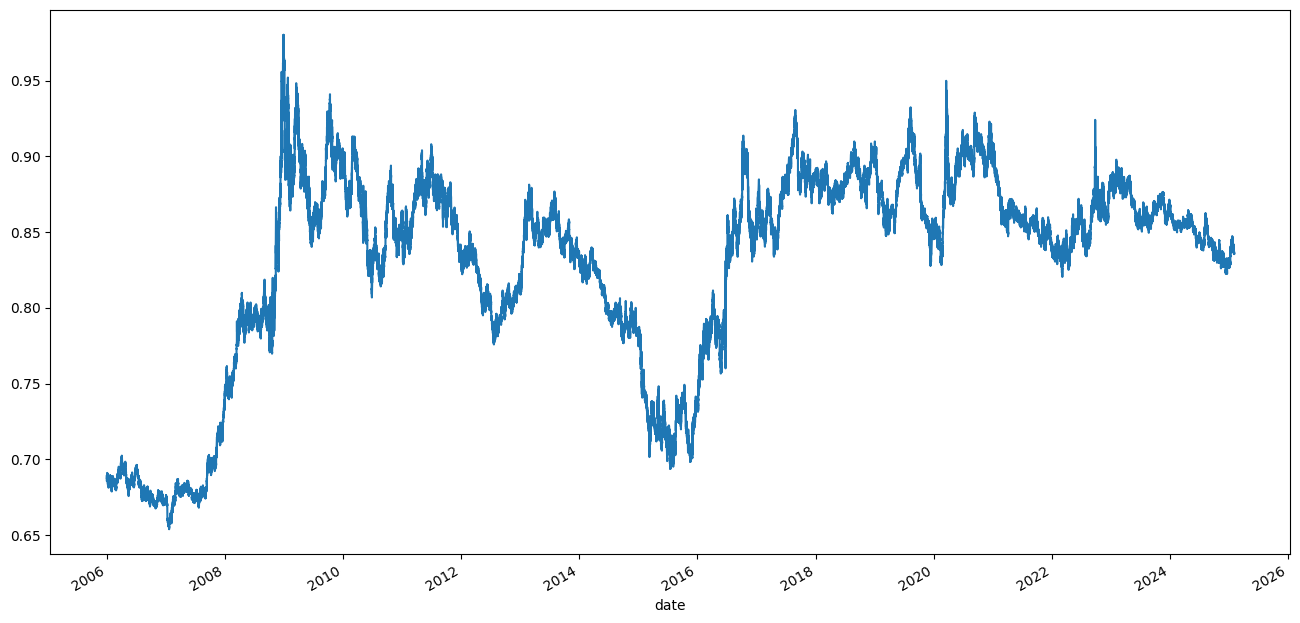

In [1]:
import cudf as cf

eurgbp = cf.read_parquet('/home/edoardocame/Desktop/python_dir/data/eurgbp_merged.parquet')

close = eurgbp['close'].to_pandas()
close.plot(figsize=(16, 8))


## Realized volatilty based on bid-ask spread using tick data

Here I want to quantify volatility via the bid-ask spread of the instrument. I'll use operations such as resampling.

In [ ]:
import cudf as cf

eurgbp_tick = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/tick_data/eurgbp-tick-2015-01-01-2025-02-03T16:47.csv')

eurgbp_tick['timestamp'] = cf.to_datetime(eurgbp_tick['timestamp'])
eurgbp_tick = eurgbp_tick.set_index('timestamp')

eurgbp_tick['spread'] = eurgbp_tick['askPrice'] - eurgbp_tick['bidPrice']
eurgbp_tick['spread'] = eurgbp_tick['spread'].abs() * 100000

spreads = eurgbp_tick['spread']
spreads = spreads.resample('D').sum().fillna(0)
print(spreads.head())

In [ ]:
spreads.to_pandas().plot()